<a href="https://colab.research.google.com/github/marinebon/py-dwc-viz/blob/main/notebooks/obis_dataset_context.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyobis



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 7.6 MB/s eta 0:00:00


In [ ]:
DATASET_HIGHLIGHT = ""
SPECIES_HIGHLIGHT = ""  # assumed to be in DATASET

# get dataset spatiotemporal extent
DATASET_BB = ""
DATASET_MIN_DT = ""
DATASET_MAX_DT = ""

# for selected species in DATASET:
#   pyobis.occurrence search for species with
#   expanded bounding box and min/max dt

    # plot records with those from DATASET_HIGHLIGHT in a separate color
    # leaflet points plot
    # temporal stacked bar chart

In [33]:
# !!! NOT WORKING
# this workflow attempts to use occurrences.search and group by datasetID,
# but the occurrence API does not return datasetID.

import math
from typing import List, Tuple, Optional, Dict, Any
import pandas as pd
import matplotlib.pyplot as plt
import folium
from shapely import wkt

from pyobis import occurrences as obis_occurrences
from pyobis import dataset as obis_dataset


def expand_bbox(bbox: Tuple[float, float, float, float], expand_km: float) -> Tuple[float, float, float, float]:
    print(f"Expanding bbox {bbox} by {expand_km} km")
    minlon, minlat, maxlon, maxlat = bbox
    deg_lat = expand_km / 110.574
    mean_lat = (minlat + maxlat) / 2.0
    deg_lon = expand_km / (111.320 * math.cos(math.radians(mean_lat)))
    expanded = (minlon - deg_lon, minlat - deg_lat, maxlon + deg_lon, maxlat + deg_lat)
    print(f"Expanded bbox: {expanded}")
    return expanded


def bbox_to_wkt_polygon(bbox: Tuple[float, float, float, float]) -> str:
    minlon, minlat, maxlon, maxlat = bbox
    coords = [
        (minlon, minlat),
        (minlon, maxlat),
        (maxlon, maxlat),
        (maxlon, minlat),
        (minlon, minlat),
    ]
    coord_str = ", ".join(f"{lon} {lat}" for lon, lat in coords)
    wkt_poly = f"POLYGON(({coord_str}))"
    print(f"Generated WKT polygon: {wkt_poly}")
    return wkt_poly


def get_dataset_metadata(dataset_id: str) -> Dict[str, Any]:
    print(f"Fetching metadata for dataset {dataset_id}")
    resp = obis_dataset.get(id=dataset_id).execute()
    print(f"Dataset metadata response keys: {list(resp.keys()) if isinstance(resp, dict) else type(resp)}")

    meta = {"raw": resp, "bbox": None, "min_date": None, "max_date": None}

    if isinstance(resp, dict) and "results" in resp and resp["results"]:
        record = resp["results"][0]
        extent = record.get("extent")
        print(f"Extent from dataset: {extent}")

        if extent:
            try:
                geom = wkt.loads(extent)
                if geom.geom_type.lower() == "polygon":
                    minx, miny, maxx, maxy = geom.bounds
                    meta["bbox"] = (minx, miny, maxx, maxy)
                    print(f"Parsed bbox: {meta['bbox']}")
            except Exception as e:
                print(f"Failed to parse WKT extent: {e}")

        meta["min_date"] = "2000-01-01"
        meta["max_date"] = "2030-01-01"
    else:
        print(f"No results found for dataset {dataset_id}")

    return meta

def query_species_occurrences(
    species: str,
    bbox: Tuple[float, float, float, float],
    startdate: Optional[str] = None,
    enddate: Optional[str] = None,
    limit: int = 10000,
    offset: int = 0,
) -> pd.DataFrame:
    print(f"Querying occurrences for {species} within {bbox} from {startdate} to {enddate}")
    wkt_poly = bbox_to_wkt_polygon(bbox)

    try:
        q = obis_occurrences.search(
            scientificname=species,
            geometry=wkt_poly,
            startdate=startdate,
            enddate=enddate,
            size=limit,
            offset=offset,
            cache=True,
        )
        resp = q.execute()
        print(f"OBIS query executed. Response type: {type(resp)}")
    except Exception as e:
        print(f"Error querying OBIS for {species}: {e}")
        return pd.DataFrame()

    df = resp
    print(f"df:{df}")
    df = df.rename(columns={"decimalLongitude": "lon", "decimalLatitude": "lat"})
    df["eventDate_parsed"] = pd.to_datetime(df.get("eventDate"), errors="coerce", utc=True)

    needed = ["lon", "lat", "datasetID", "scientificName", "eventDate_parsed"]
    for c in needed:
        if c not in df.columns:
            df[c] = pd.NA

    # 🔍 Print unique dataset IDs to inspect how they're represented
    for key in ["datasetID", "dataset_id"]:
        if key in df.columns:
            unique_vals = df[key].dropna().unique().tolist()
            print(f"Unique values in {key} ({len(unique_vals)}): {unique_vals[:10]}")
            if len(unique_vals) > 10:
                print(f"... ({len(unique_vals) - 10} more)")

    print(f"Final cleaned DataFrame columns: {df.columns.tolist()}")
    return df[needed].copy()



def build_leaflet_map(df: pd.DataFrame, dataset_highlight: str, out_html: Optional[str] = None) -> folium.Map:
    print(f"Building map with {len(df)} total records")

    # Normalize dataset ID field
    if "datasetID" not in df.columns and "dataset_id" in df.columns:
        print("Renaming 'dataset_id' → 'datasetID' for consistency")
        df = df.rename(columns={"dataset_id": "datasetID"})
    elif "datasetID" in df.columns:
        print("'datasetID' column already present")

    print(f"Unique datasetIDs in dataframe: {df['datasetID'].dropna().unique().tolist()}")

    df2 = df.dropna(subset=["lon", "lat"]).copy()
    if df2.empty:
        print("No valid lat/lon records for map.")
        m = folium.Map(location=[0, 0], zoom_start=2)
        if out_html:
            m.save(out_html)
        return m

    mean_lat = df2["lat"].astype(float).mean()
    mean_lon = df2["lon"].astype(float).mean()
    print(f"Map center: lat={mean_lat}, lon={mean_lon}")

    # Debug: Check how many match the highlight dataset
    match_mask = df2["datasetID"].astype(str) == str(dataset_highlight)
    print(f"Records matching dataset_highlight={dataset_highlight}: {match_mask.sum()} of {len(df2)}")

    m = folium.Map(location=[mean_lat, mean_lon], zoom_start=4, control_scale=True)
    fg_high = folium.FeatureGroup(name=f"Dataset {dataset_highlight}", show=True)
    fg_other = folium.FeatureGroup(name="Other datasets", show=True)

    for _, row in df2.iterrows():
        lat = float(row["lat"])
        lon = float(row["lon"])
        popup_html = f"{row.get('scientificName', '')}<br>dataset: {row.get('datasetID','')}"
        popup = folium.Popup(popup_html, max_width=300)
        if str(row["datasetID"]) == str(dataset_highlight):
            folium.CircleMarker(location=(lat, lon), radius=4, color="red", fill=True, fill_opacity=0.9, popup=popup).add_to(fg_high)
        else:
            folium.CircleMarker(location=(lat, lon), radius=3, color="blue", fill=True, fill_opacity=0.6, popup=popup).add_to(fg_other)

    fg_high.add_to(m)
    fg_other.add_to(m)
    folium.LayerControl().add_to(m)

    if out_html:
        m.save(out_html)
        print(f"Saved map to {out_html}")
    return m


def temporal_stacked_chart(df: pd.DataFrame, dataset_highlight: str, out_png: Optional[str] = None, freq: str = "M"):
    print(f"Building temporal chart for {len(df)} records")

    # Normalize dataset ID field
    if "datasetID" not in df.columns and "dataset_id" in df.columns:
        print("Renaming 'dataset_id' → 'datasetID' for consistency")
        df = df.rename(columns={"dataset_id": "datasetID"})
    elif "datasetID" in df.columns:
        print("'datasetID' column already present")

    print(f"Unique datasetIDs in dataframe: {df['datasetID'].dropna().unique().tolist()}")

    df2 = df.dropna(subset=["eventDate_parsed"]).copy()
    if df2.empty:
        print("No dated records for chart.")
        return None

    df2["period"] = df2["eventDate_parsed"].dt.to_period(freq)
    df2["period_ts"] = df2["period"].dt.to_timestamp()
    df2["is_highlight"] = df2["datasetID"].astype(str) == str(dataset_highlight)

    # Debug print
    print(f"Highlight matches: {df2['is_highlight'].sum()} of {len(df2)} records")

    grouped = df2.groupby(["period_ts", "is_highlight"]).size().unstack(fill_value=0)
    grouped = grouped.rename(columns={True: "highlight_dataset", False: "other_datasets"}).sort_index()
    print(f"Temporal grouping complete with {len(grouped)} periods")

    fig, ax = plt.subplots(figsize=(12, 5))
    grouped.plot(kind="bar", stacked=True, ax=ax, rot=45)
    ax.set_xlabel("Time")
    ax.set_ylabel("Record count")
    ax.set_title("Temporal counts: highlight dataset vs others")
    plt.tight_layout()

    if out_png:
        fig.savefig(out_png, dpi=150)
        print(f"Saved chart to {out_png}")
    return fig



def run_workflow(
    DATASET_HIGHLIGHT: str,
    SPECIES_HIGHLIGHT: List[str],
    expand_km: float = 50.0,
    out_map_html: Optional[str] = "obis_map.html",
    out_chart_png: Optional[str] = "temporal_stack.png",
    query_limit: int = 20000,
) -> Dict[str, Any]:
    print(f"Running workflow for dataset {DATASET_HIGHLIGHT} with species: {SPECIES_HIGHLIGHT}")
    meta = get_dataset_metadata(DATASET_HIGHLIGHT)
    bbox = meta.get("bbox")
    if bbox is None:
        raise RuntimeError(f"Could not get bounding box for dataset {DATASET_HIGHLIGHT}")

    expanded = expand_bbox(bbox, expand_km)
    all_dfs = []

    for sp in SPECIES_HIGHLIGHT:
        print(f"Querying species: {sp}")
        df = query_species_occurrences(
            sp, expanded,
            startdate=meta["min_date"],
            enddate=meta["max_date"],
            limit=query_limit
        )
        print(f"Returned {len(df)} rows for species {sp}")
        df["queried_species"] = sp
        all_dfs.append(df)

    if not all_dfs:
        raise RuntimeError("No species queries produced results.")

    combined = pd.concat(all_dfs, ignore_index=True, sort=False)
    print(f"Total combined records: {len(combined)}")

    m = build_leaflet_map(combined, DATASET_HIGHLIGHT, out_html=out_map_html)
    fig = temporal_stacked_chart(combined, DATASET_HIGHLIGHT, out_png=out_chart_png)

    return {
        "metadata": meta,
        "expanded_bbox": expanded,
        "combined_df": combined,
        "map": m,
        "chart_fig": fig,
    }


In [43]:
def get_datasets_for_species(
    species: str,
    bbox: Tuple[float, float, float, float],
    startdate: str,
    enddate: str,
    limit: int = 50
) -> pd.DataFrame:
    """
    Query OBIS for datasets overlapping the bounding box and species/timespan.
    Returns a DataFrame of dataset metadata including 'id' and 'title'.
    """
    wkt_poly = bbox_to_wkt_polygon(bbox)
    print(f"Searching datasets for species '{species}' in bbox {bbox} and dates {startdate} to {enddate}")

    resp = obis_dataset.search(
        geometry=wkt_poly,
        scientificname=species,
        startdate=startdate,
        enddate=enddate,
        size=limit
    ).execute()

    if isinstance(resp, dict) and "results" in resp:
        datasets = pd.json_normalize(resp["results"])
    else:
        datasets = pd.DataFrame()

    print(f"Found {len(datasets)} datasets for species {species}")
    if not datasets.empty:
        print("Sample datasets:")
        print(datasets[["id", "title"]].head(5))

    return datasets

def get_occurrences_for_species_datasets(
    species: str,
    dataset_ids: List[str],
    startdate: str,
    enddate: str,
    limit: int = 10000
) -> pd.DataFrame:
    """
    Query OBIS occurrences for a species from a list of datasets.
    Returns a combined DataFrame with a column 'dataset_id' identifying the dataset.
    """
    all_records = []

    for dsid in dataset_ids:
        print(f"Querying occurrences for species '{species}' from dataset {dsid}")
        try:
            resp = obis_occurrences.search(
                scientificname=species,
                datasetid=dsid,
                startdate=startdate,
                enddate=enddate,
                size=limit
            ).execute()

            if isinstance(resp, dict) and "results" in resp:
                df = pd.json_normalize(resp["results"])
            elif isinstance(resp, pd.DataFrame):
                df = resp.copy()
            else:
                df = pd.DataFrame()

            if not df.empty:
                df["dataset_id"] = dsid  # mark the dataset explicitly
                # normalize columns
                df = df.rename(columns={"decimalLongitude": "lon", "decimalLatitude": "lat"})
                df["eventDate_parsed"] = pd.to_datetime(df.get("eventDate"), errors="coerce", utc=True)
                needed_cols = ["lon", "lat", "dataset_id", "scientificName", "eventDate_parsed"]
                for c in needed_cols:
                    if c not in df.columns:
                        df[c] = pd.NA
                df = df[needed_cols]
                all_records.append(df)
                print(f" - Retrieved {len(df)} records from dataset {dsid}")
            else:
                print(f" - No occurrences found in dataset {dsid}")
        except Exception as e:
            print(f"Error querying dataset {dsid}: {e}")

    if all_records:
        combined = pd.concat(all_records, ignore_index=True)
    else:
        combined = pd.DataFrame(columns=["lon", "lat", "dataset_id", "scientificName", "eventDate_parsed"])

    print(f"Total combined occurrences: {len(combined)}")
    return combined

def run_workflow_datasets(
    SPECIES_HIGHLIGHT: List[str],
    DATASET_HIGHLIGHT: str,
    expand_bbox_km: float = 50.0,
    out_map_html: Optional[str] = "obis_map.html",
    out_chart_png: Optional[str] = "temporal_stack.png",
):
    all_occurrences = []
    all_datasets = []

    for sp in SPECIES_HIGHLIGHT:
        # 1. Query initial datasets for this species
        # (startdate/enddate could be passed in or fixed for now)
        datasets = get_datasets_for_species(
            species=sp,
            bbox=(-180, -90, 180, 90),  # global default; could be replaced with expanded bbox
            startdate="2000-01-01",
            enddate="2030-01-01",
        )
        if datasets.empty:
            print(f"No datasets found for species {sp}")
            continue

        all_datasets.append(datasets)
        dataset_ids = datasets["id"].tolist()

        # 2. Query occurrences for this species from each dataset
        df_occ = get_occurrences_for_species_datasets(
            species=sp,
            dataset_ids=dataset_ids,
            startdate="2000-01-01",
            enddate="2030-01-01",
        )
        df_occ["queried_species"] = sp
        all_occurrences.append(df_occ)

    if not all_occurrences:
        print("No occurrences retrieved for any species.")
        return {}

    combined_occurrences = pd.concat(all_occurrences, ignore_index=True)
    print(f"Total occurrences across all species: {len(combined_occurrences)}")

    # Build map and chart using 'dataset_id' for highlighting
    # Here you could pick a dataset to highlight, or just show all
    if not DATASET_HIGHLIGHT in combined_occurrences["dataset_id"]:
        print(f"ERR: DATASET_HIGHLIGHT '{DATASET_HIGHLIGHT}' not in combined_occurrences['dataset_id']")

    m = build_leaflet_map(combined_occurrences, dataset_highlight=DATASET_HIGHLIGHT, out_html=out_map_html)
    fig = temporal_stacked_chart(combined_occurrences, dataset_highlight=DATASET_HIGHLIGHT, out_png=out_chart_png)

    return {
        "combined_occurrences": combined_occurrences,
        "all_datasets": pd.concat(all_datasets, ignore_index=True) if all_datasets else pd.DataFrame(),
        "map": m,
        "chart_fig": fig
    }


Generated WKT polygon: POLYGON((-180 -90, -180 90, 180 90, 180 -90, -180 -90))
Searching datasets for species 'Siphonaria lessonii' in bbox (-180, -90, 180, 90) and dates 2000-01-01 to 2030-01-01
Found 6 datasets for species Siphonaria lessonii
Sample datasets:
                                     id  \
0  81db945e-d319-4237-b49e-cd3e78937393   
1  1d8fb994-64af-4a57-abe2-19573cc91f85   
2  e4a2fe06-f082-4f36-9165-73263a121508   
3  0c59dc30-4b06-4572-addc-155042f81fd0   
4  654a42e9-195a-40a4-a492-290b9eadbaa8   

                                               title  
0                                  sarce_rockyshores  
1  MBON POLE TO POLE: ROCKY SHORE BIODIVERSITY OF...  
2   MBON POLE TO POLE:  ROCKY SHORE BIODIVERSITY ...  
3                                     NaGISA Project  
4  MBON POLE TO POLE: ROCKY SHORE BIODIVERSITY OF...  
Querying occurrences for species 'Siphonaria lessonii' from dataset 81db945e-d319-4237-b49e-cd3e78937393
 - Retrieved 564 records from dataset 81db94

/tmp/ipython-input-3349859262.py:186: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df2["period"] = df2["eventDate_parsed"].dt.to_period(freq)


Saved chart to temporal_stack.png


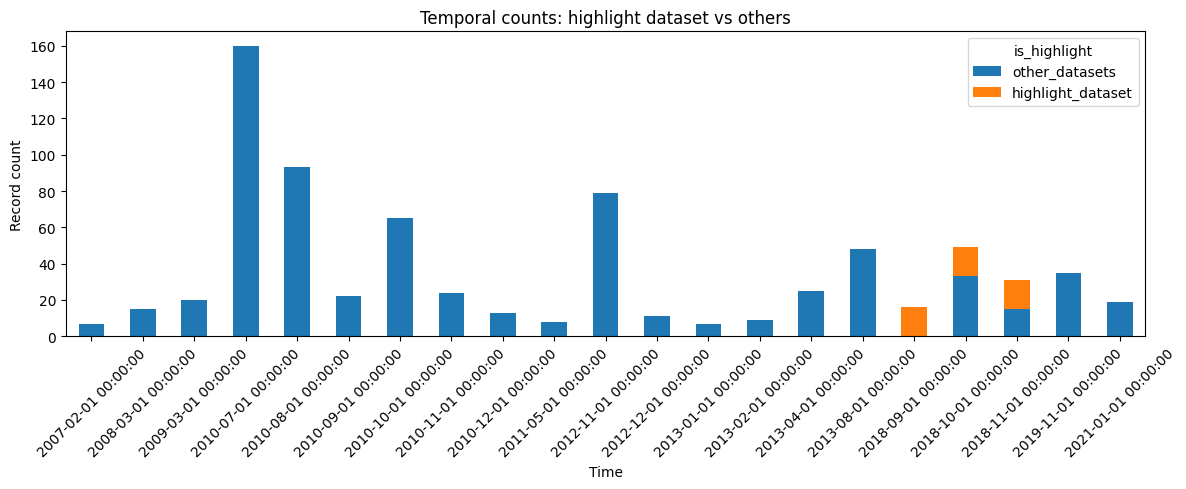

In [44]:
res = run_workflow_datasets(
    DATASET_HIGHLIGHT="e4a2fe06-f082-4f36-9165-73263a121508",
    SPECIES_HIGHLIGHT= ["Siphonaria lessonii"],
)


In [45]:
res['map']